![AIcrowd-Logo](https://raw.githubusercontent.com/AIcrowd/AIcrowd/master/app/assets/images/misc/aicrowd-horizontal.png)

# Solution Code for [Chess Educational Challenge](https://www.aicrowd.com/challenges/chess-predict-win-depth)
#### Author : TeamBlitzCA

## Download Necessary Packages 📚

In [21]:
! pip install numpy
! pip install pandas
! pip install scikit-learn
! pip install catboost

     |████████████████████████████████| 64.8MB 59kB/s 


In [2]:
!git clone https://github.com/michiguel/Gaviota-Tablebases

Cloning into 'Gaviota-Tablebases'...
remote: Enumerating objects: 1236, done.
remote: Total 1236 (delta 0), reused 0 (delta 0), pack-reused 1236
Receiving objects: 100% (1236/1236), 1010.17 KiB | 12.63 MiB/s, done.
Resolving deltas: 100% (500/500), done.


## Download Data
The first step is to download out train test data. We will be training a model on the train data and make predictions on test data. We submit our predictions


In [3]:
#Donwload the datasets
!rm -rf data
!mkdir data
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/chess/v0.1/test.csv
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/chess/v0.1/train.csv
!mv train.csv data/train.csv
!mv test.csv data/test.csv

--2020-07-26 06:54:40--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/chess/v0.1/test.csv
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.12, 130.117.252.17, 130.117.252.16, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67344 (66K) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]  65.77K   358KB/s    in 0.2s    

2020-07-26 06:54:41 (358 KB/s) - ‘test.csv’ saved [67344/67344]

--2020-07-26 06:54:42--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/chess/v0.1/train.csv
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.12, 130.117.252.17, 130.117.252.16, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.12|:443... connected.
HTTP request sent, awaiting response... 20


## Import packages

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import chess
import chess.syzygy
import chess.gaviota
from tqdm import tqdm as tqdm
import catboost as ctb

## Load Data
- We use pandas 🐼 library to load our data.   
- Pandas loads the data into dataframes and facilitates us to analyse the data.   
- Learn more about it [here](https://www.tutorialspoint.com/python_data_science/python_pandas.htm) 🤓

In [5]:
train_path = "data/train.csv" #path where data is stored
test_path = "data/test.csv"

In [6]:
train = pd.read_csv(train_path) #load data in dataframe using pandas
test =  pd.read_csv(test_path)

## Visualize the data 👀

In [8]:
#Rename Columns

train.columns = ['WK Column', 'WK Row', 'WR Column', 'WR Row', 'BK Column', 'BK Row', 'Number of Moves']
test.columns =  ['WK Column', 'WK Row', 'WR Column', 'WR Row', 'BK Column', 'BK Row']


train.head()

,WK Column,WK Row,WR Column,WR Row,BK Column,BK Row,Number of Moves
0,3,1,8,2,6,4,14
1,2,2,7,7,6,2,14
2,3,1,3,3,7,7,14
3,4,1,8,2,1,1,4
4,3,1,1,5,5,3,13


## Feature Engineering


In [9]:
def CreateFenFormat(df):

    full_fen = []


    for i in range(len(df)):
        WKR = df.loc[i, 'WK Row']
        WKC = df.loc[i, 'WK Column']
        WRR = df.loc[i, 'WR Row']
        WRC = df.loc[i, 'WR Column']
        BKR = df.loc[i, 'BK Row']
        BKC = df.loc[i, 'BK Column']
    
    
        list_of_rows = list([WKR, WRR, BKR])
        list_of_cols = list([WKC, WRC, BKC])
    
        if len(set(list_of_rows)) == 3:
            fen_list = ['8','8','8','8','8','8','8','8']
            fen_list[WKR - 1] = str(WKC- 1)+'K'+ str(8 - WKC)
            fen_list[WRR - 1] = str(WRC - 1)+'R'+ str(8 -WRC)
            fen_list[BKR - 1] = str(BKC - 1)+'k'+ str(8 -BKC)                                                                                     
        
            for j in range(len(fen_list)):
                if '0' in fen_list[j]:
                    fen_list[j] = fen_list[j].replace('0', '')
                
       
            string_ = fen_list[0]+'/'+fen_list[1]+'/'+fen_list[2]+'/'+fen_list[3]+'/'+fen_list[4]+'/'+fen_list[5]+'/'+fen_list[6]+'/'+fen_list[7]+' b - - 0 1'
            full_fen.append(string_)
        
        
        
        elif len(set(list_of_rows)) == 2 and (list_of_rows[0]==list_of_rows[1]):
            fen_list = ['8','8','8','8','8','8','8','8']
            diff = abs(WKC - WRC)
            if WKC == min(WKC,WRC):
                fen_list[WKR - 1] = str(WKC-1)+'K'+str(diff-1)+'R'+str(8-WRC)
            else:
                fen_list[WKR - 1] = str(WRC-1)+'R'+str(diff-1)+'K'+str(8-WKC)
            
            fen_list[BKR - 1] = str(BKC - 1)+'k'+ str(8 -BKC) 
        
            for j in range(len(fen_list)):
                if '0' in fen_list[j]:
                    fen_list[j] = fen_list[j].replace('0', '')
                
            string_ = fen_list[0]+'/'+fen_list[1]+'/'+fen_list[2]+'/'+fen_list[3]+'/'+fen_list[4]+'/'+fen_list[5]+'/'+fen_list[6]+'/'+fen_list[7]+' b - - 0 1'
            full_fen.append(string_)
                
        
        elif len(set(list_of_rows)) == 2 and (list_of_rows[0]==list_of_rows[2]):
            fen_list = ['8','8','8','8','8','8','8','8']
            diff = abs(WKC - BKC)
            if WKC == min(WKC,BKC):
                fen_list[WKR - 1] = str(WKC-1)+'K'+str(diff-1)+'k'+str(8-BKC)
            else:
                fen_list[WKR - 1] = str(BKC-1)+'k'+str(diff-1)+'K'+str(8-WKC)
            
            fen_list[WRR - 1] = str(WRC - 1)+'R'+ str(8 -WRC)  
        
            for j in range(len(fen_list)):
                if '0' in fen_list[j]:
                    fen_list[j] = fen_list[j].replace('0', '')
                
            string_ = fen_list[0]+'/'+fen_list[1]+'/'+fen_list[2]+'/'+fen_list[3]+'/'+fen_list[4]+'/'+fen_list[5]+'/'+fen_list[6]+'/'+fen_list[7]+' b - - 0 1'
            full_fen.append(string_)
            
            
        elif len(set(list_of_rows)) == 2 and (list_of_rows[1]==list_of_rows[2]):
            fen_list = ['8','8','8','8','8','8','8','8']
            diff = abs(WRC - BKC)
            if WRC == min(WRC,BKC):
                fen_list[WRR - 1] = str(WRC-1)+'R'+str(diff-1)+'k'+str(8-BKC)
            else:
                fen_list[WRR - 1] = str(BKC-1)+'k'+str(diff-1)+'R'+str(8-WRC)
    
            fen_list[WKR - 1] = str(WKC- 1)+'K'+ str(8 - WKC)
        
            for j in range(len(fen_list)):
                if '0' in fen_list[j]:
                    fen_list[j] = fen_list[j].replace('0', '')
                
            string_ = fen_list[0]+'/'+fen_list[1]+'/'+fen_list[2]+'/'+fen_list[3]+'/'+fen_list[4]+'/'+fen_list[5]+'/'+fen_list[6]+'/'+fen_list[7]+' b - - 0 1'
            full_fen.append(string_)
        
        
        elif len(set(list_of_rows)) == 1:
            fen_list = ['8','8','8','8','8','8','8','8']
            if (WKC == min(WKC,WRC,BKC)) and (WRC==max(WKC,WRC,BKC)):
                diff1 = BKC-WKC
                diff2 = WRC - BKC
                fen_list[WKR - 1] = str(WKC-1)+'K'+str(diff1-1)+'k'+str(diff2-1)+'R'+str(8-WRC)
            elif (WRC == min(WKC,WRC,BKC)) and (WKC==max(WKC,WRC,BKC)):
                diff1 = BKC-WRC
                diff2 = WKC - BKC
                fen_list[WKR - 1] = str(WRC-1)+'R'+str(diff1-1)+'k'+str(diff2-1)+'K'+str(8-WKC)
            
            elif (WRC == min(WKC,WRC,BKC)) and (BKC==max(WKC,WRC,BKC)):
                diff1 = WKC-WRC
                diff2 = BKC - WKC
                fen_list[WKR - 1] = str(WRC-1)+'R'+str(diff1-1)+'K'+str(diff2-1)+'k'+str(8-BKC)
            
            elif (WKC == min(WKC,WRC,BKC)) and (BKC==max(WKC,WRC,BKC)):
                diff1 = WRC-WKC
                diff2 = BKC - WRC
                fen_list[WKR - 1] = str(WKC-1)+'K'+str(diff1-1)+'R'+str(diff2-1)+'k'+str(8-BKC)
            
            elif (BKC == min(WKC,WRC,BKC)) and (WKC==max(WKC,WRC,BKC)):
                diff1 = WRC-BKC
                diff2 = WKC - WRC
                fen_list[WKR - 1] = str(BKC-1)+'k'+str(diff1-1)+'R'+str(diff2-1)+'K'+str(8-WKC)
            
            elif (BKC == min(WKC,WRC,BKC)) and (WRC==max(WKC,WRC,BKC)):
                diff1 = WKC-BKC
                diff2 = WRC - WKC
                fen_list[WKR - 1] = str(BKC-1)+'k'+str(diff1-1)+'K'+str(diff2-1)+'R'+str(8-WRC)
            
            for j in range(len(fen_list)):
                if '0' in fen_list[j]:
                    fen_list[j] = fen_list[j].replace('0', '')
                
            string_ = fen_list[0]+'/'+fen_list[1]+'/'+fen_list[2]+'/'+fen_list[3]+'/'+fen_list[4]+'/'+fen_list[5]+'/'+fen_list[6]+'/'+fen_list[7]+' b - - 0 1'
            full_fen.append(string_)
            
    df['fen'] = full_fen
    
    return df

In [10]:
train = CreateFenFormat(train)
test = CreateFenFormat(test)

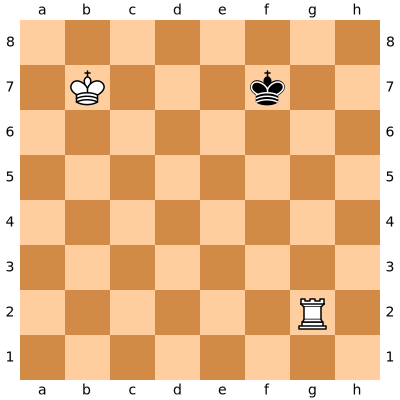

In [11]:
#Show the board for the first position in train
board = chess.Board(train.loc[1, 'fen'])
board

In [12]:
_len = len(train)

df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [15]:
fen_moves = []

for i in tqdm(range(len(df))):
    fen = df.loc[i, 'fen']
    with chess.gaviota.open_tablebases('Gaviota-Tablebases/gtb/gtb4/') as tablebase:
        board = chess.Board(fen)
        depth = tablebase.get_dtm(board)
        fen_moves.append(depth)

100%|██████████| 28055/28055 [24:07<00:00, 19.38it/s]


In [17]:
df['depth'] = fen_moves

In [18]:
train = df[:_len]
test = df[_len:]

## TRAINING AND PREDICTION


In [19]:
X = train.drop(['Number of Moves', 'fen'], axis=1)
y = train['Number of Moves']

In [23]:
model = ctb.CatBoostClassifier()

model.fit(X, y)

Learning rate set to 0.092732
0:	learn: 1.8308639	total: 108ms	remaining: 1m 47s
1:	learn: 1.5522729	total: 164ms	remaining: 1m 21s
2:	learn: 1.3795887	total: 223ms	remaining: 1m 14s
3:	learn: 1.2167436	total: 279ms	remaining: 1m 9s
4:	learn: 1.0791320	total: 335ms	remaining: 1m 6s
5:	learn: 0.9855803	total: 403ms	remaining: 1m 6s
6:	learn: 0.9089325	total: 463ms	remaining: 1m 5s
7:	learn: 0.8180258	total: 519ms	remaining: 1m 4s
8:	learn: 0.7294908	total: 579ms	remaining: 1m 3s
9:	learn: 0.6677139	total: 636ms	remaining: 1m 2s
10:	learn: 0.6162262	total: 695ms	remaining: 1m 2s
11:	learn: 0.5664526	total: 751ms	remaining: 1m 1s
12:	learn: 0.5188907	total: 808ms	remaining: 1m 1s
13:	learn: 0.4881986	total: 871ms	remaining: 1m 1s
14:	learn: 0.4462846	total: 935ms	remaining: 1m 1s
15:	learn: 0.4150513	total: 993ms	remaining: 1m 1s
16:	learn: 0.3877297	total: 1.05s	remaining: 1m
17:	learn: 0.3553526	total: 1.11s	remaining: 1m
18:	learn: 0.3324366	total: 1.17s	remaining: 1m
19:	learn: 0.3119

In [24]:
X_test = test.drop(['Number of Moves', 'fen'], axis=1)

In [26]:
pred = model.predict(X_test)

In [27]:
pd.DataFrame(pred).to_csv('submission.csv', header=['depth'], index=False)